In [639]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from keras.models import Sequential, Model
from keras import layers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

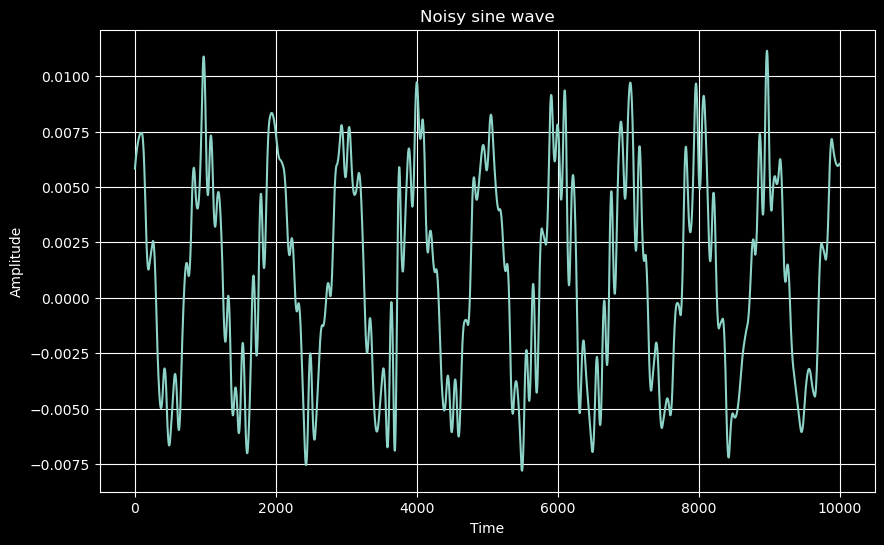

In [640]:
def generate_smooth_noisy_sine(wave_length=10000, noise_factor=0.5, frequency=1, num_periods=1, seed=None, sparsity=100, ascending=0.0):
    if seed is not None:
        np.random.seed(seed)
    t = np.arange(0, wave_length)
    x = np.linspace(0, 2*np.pi*num_periods, wave_length)
    pure_sine = np.sin(frequency*x)
    pure_sine = pure_sine + ascending * t
    
    # Генерируем разреженный шум
    sparse_x = np.linspace(0, 2*np.pi*num_periods, wave_length // sparsity)
    sparse_noise = np.random.normal(0, noise_factor, wave_length // sparsity)
    
    # Интерполируем разреженный шум на полный диапазон x
    noise_interp = interp1d(sparse_x, sparse_noise, kind='cubic', fill_value="extrapolate")
    noise = noise_interp(x)
    
    noisy_sine = pure_sine + noise
    return x, noisy_sine

_, ideal_sine = generate_smooth_noisy_sine(noise_factor=0.05, num_periods=10, seed=42, sparsity=50, ascending=0.001)
diff = np.diff(ideal_sine)

plt.figure(figsize=(10, 6))
plt.plot(diff)
plt.title('Noisy sine wave')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

In [671]:
def make_observation_window(data,window_size:int):
    X, y = [], []
    for i in range(window_size, len(data) - 5):
        X.append(data[i - window_size:i])
        y.append(data[i:i + 5])
    return np.array(X), np.array(y)

window = 500
X, y = make_observation_window(diff, window_size=window)
X = X[:,:,None]

# split_index = int(len(ideal_sine) * 0.8)
# X_train = X[:split_index]
# X_test = X[split_index:]
# y_train = y[:split_index]
# y_test = y[split_index:]

scaler = MinMaxScaler()
for i in range(X.shape[0]):
    X[i] = scaler.fit_transform(X[i])# X_test = scaler.transform(X_test)
# X_train = X_train[:,:,None]
# X_test = X_test[:,:,None]

X = X.astype('float32')
y = y.astype('float32')

In [672]:
print(X.shape)
print(y.shape)

(9494, 500, 1)
(9494, 5)


In [673]:

early_stopping = EarlyStopping(monitor='mae',  # метрика для мониторинга
                               patience=4,  # количество эпох, в течение которых можно пропустить улучшение
                               verbose=1,  # выводит сообщение, когда обучение останавливается
                               restore_best_weights=True)  # восстанавливает лучшие веса, найденные во время обучения
model = Sequential([
    layers.InputLayer(input_shape=(X.shape[1], X.shape[2])),
    layers.Conv1D(filters=4, kernel_size=20, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2, padding='same'),
    layers.Conv1D(filters=8, kernel_size=10, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2, padding='same'),
    # layers.Conv1D(filters=32, kernel_size=3, activation='tanh', padding='same'),
    # # layers.MaxPooling1D(pool_size=2, padding='same'),
    # layers.Conv1D(filters=16, kernel_size=3, activation='tanh', padding='same'),
    # # layers.MaxPooling1D(pool_size=2, padding='same'),
    # layers.Conv1D(filters=32, kernel_size=3, activation='tanh', padding='same'),
    # # layers.MaxPooling1D(pool_size=2, padding='same'),
    # layers.Conv1D(filters=128, kernel_size=3, activation='tanh', padding='same'),
    # layers.MaxPooling1D(pool_size=2, padding='same'),
    # layers.LSTM(50, return_sequences=True, activation='tanh'),
    layers.LSTM(1024, activation='tanh'),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.05),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.05),
    layers.Dense(5, activation='linear')
])

# Компиляция модели
model.compile(optimizer='adam',
              loss='mse',
              metrics='mae',
              )

# Обучение модели
# class_weights = {0: 1., 1: 20.}  # 1:20
history = model.fit(
    X,
    y,
    epochs=100,
    batch_size=256,
    # validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping],
    # class_weight=class_weights,
)

# Оценка модели с использованием другой метрики
# model.compile(metrics=[tf.keras.metrics.AUC(name='auc'), f1_metric])
# test_loss, test_mape = model.evaluate(X_test, y_test)
# print(f"Test accuracy: {test_accuracy:.4f}, test_f1: {test_f1:.4f}")
# print(f"Test loss: {test_loss:.4f}, val_mape: {test_mape:.4f}")

Epoch 1/100
38/38 [==============================] - 7s 142ms/step - loss: 1.4648e-04 - mae: 0.0046
Epoch 2/100
38/38 [==============================] - 5s 141ms/step - loss: 5.9254e-06 - mae: 0.0020
Epoch 3/100
38/38 [==============================] - 5s 142ms/step - loss: 5.0818e-06 - mae: 0.0018
Epoch 4/100
38/38 [==============================] - 5s 142ms/step - loss: 3.9631e-06 - mae: 0.0015
Epoch 5/100
38/38 [==============================] - 5s 143ms/step - loss: 3.3549e-06 - mae: 0.0014
Epoch 6/100
38/38 [==============================] - 5s 143ms/step - loss: 3.2655e-06 - mae: 0.0014
Epoch 7/100
38/38 [==============================] - 5s 144ms/step - loss: 2.5658e-06 - mae: 0.0012
Epoch 8/100
38/38 [==============================] - 5s 144ms/step - loss: 2.3238e-06 - mae: 0.0012
Epoch 9/100
38/38 [==============================] - 5s 145ms/step - loss: 1.6327e-06 - mae: 9.9711e-04
Epoch 10/100
38/38 [==============================] - 5s 145ms/step - loss: 1.0119e-06 - mae: 7.

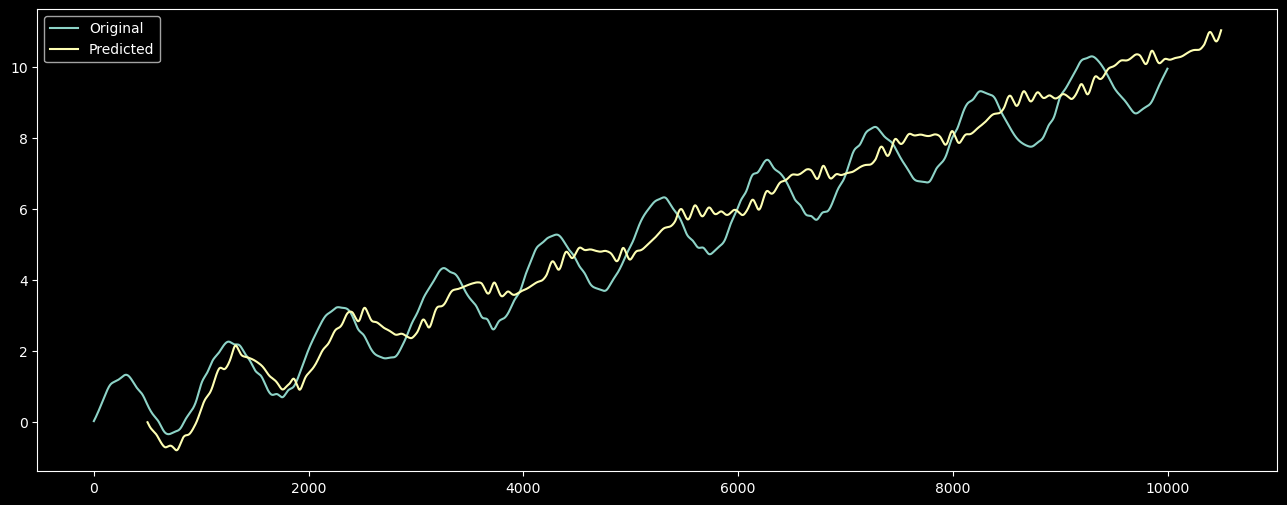

In [675]:
# Генерация нового временного ряда на основе прогнозов
test_sequence = diff[:window].tolist()
predictions = []

chart_range = 2000
for _ in range(chart_range):
    test_array = np.array(test_sequence[-window:]).reshape(-1, 1)
    test_array = scaler.fit_transform(test_array).reshape(1, window, 1)
    # test_array = np.array(test_sequence[-window:]).reshape(1, window, 1)
    out = model.predict(test_array, verbose=0)[0].tolist()
    predictions += out
    test_sequence += out

recovered = np.cumsum(predictions)

# Визуализация исходного и сгенерированного временного ряда
plt.figure(figsize=(16, 6))
plt.plot(ideal_sine[:window+chart_range*5], label='Original')  # учитываем, что каждый прогноз - это 5 точек
plt.plot(range(window, window+chart_range*5), recovered, label='Predicted')
plt.legend()
plt.show()